<a href="https://colab.research.google.com/github/AliAkbarBadri/topics-for-types/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
! pip -q install laserembeddings
! python -m laserembeddings download-models
! pip -q install transformers


In [1]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoTokenizer, AutoModel
from laserembeddings import Laser
from __future__ import unicode_literals

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Word2Vec

In [59]:
df_types_lstm = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types.csv")
df_types_lstm.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,تفاوت ترمز عقب دیسکی و کاسه ای چیست؟,0,0,0,0,1,1,0,0,0,1,0,0
1,آیا ترمز ضدقفل ABS در همه چرخ ها عمل می کند؟,0,1,0,0,0,1,0,0,0,1,0,0
2,چرا باوجود نصب بودن ترمز ABS بر روی خودرو، ترم...,0,0,0,0,0,1,1,0,0,1,0,0
3,چرا با وجود نصب بودن Airbag بر روی خودرو، در ه...,0,0,0,0,0,1,1,0,0,1,0,0
4,کلاس های مختلف خودرو چگونه شناسایی می شوند؟,0,0,0,0,1,0,0,0,1,1,0,0


In [53]:
X = df_types_lstm[df_types_lstm.columns[0]].values
Y = df_types_lstm[df_types_lstm.columns[1:]].values

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [ ]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [51]:
vocab_size, X_train.shape, y_train.shape, X_test.shape, y_test.shape

(8082, (2181, 1024), (2181, 12), (243, 1024), (243, 12))

In [ ]:
embeddings_dictionary = dict()

glove_file = open('drive/My Drive/nlp/similarity/embeddings/twitt_wiki_ham_blog.fa.text.100.vec', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(maxlen,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim = 100, 
                            weights=[embedding_matrix],
                            trainable=False, name='Embedding_Layer'),
    tf.keras.layers.LSTM(200,
                        # return_sequences=True,
                        # stateful=True,
                        recurrent_initializer='glorot_uniform',
                        name='LSTM_Layer'),
    tf.keras.layers.Dense(12, activation='sigmoid', name='Dense_Layer')
  ], name='LSTM_Model')
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['acc'])
print(model.summary())
print()
print(model.layers[0].weights)

Model: "LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_Layer (Embedding)  (None, 200, 100)          808200    
_________________________________________________________________
LSTM_Layer (LSTM)            (None, 200)               240800    
_________________________________________________________________
Dense_Layer (Dense)          (None, 12)                2412      
Total params: 1,051,412
Trainable params: 243,212
Non-trainable params: 808,200
_________________________________________________________________
None

[<tf.Variable 'Embedding_Layer/embeddings:0' shape=(8082, 100) dtype=float32, numpy=
array([[ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [-2.222517e+00, -4.284540e-01, -1.253941e+00, ...,  3.614520e-01,
         1.804778e+00, -2.163010e-01],
       [-1.325660e-01, -4.901635e+00, -1.319971e+00, ...,

In [19]:
history = model.fit(X_train, y_train, batch_size=32, epochs=15, verbose=1, validation_split=0.2)

Epoch 1/15
49/49 [==============================] - 1s 18ms/step - loss: 0.2931 - acc: 0.4952 - val_loss: 0.2952 - val_acc: 0.4588
Epoch 2/15
49/49 [==============================] - 1s 14ms/step - loss: 0.2921 - acc: 0.4952 - val_loss: 0.2946 - val_acc: 0.4588
Epoch 3/15
49/49 [==============================] - 1s 14ms/step - loss: 0.2926 - acc: 0.4945 - val_loss: 0.2946 - val_acc: 0.4588
Epoch 4/15
49/49 [==============================] - 1s 14ms/step - loss: 0.2935 - acc: 0.4952 - val_loss: 0.2998 - val_acc: 0.4588
Epoch 5/15
49/49 [==============================] - 1s 14ms/step - loss: 0.2948 - acc: 0.4952 - val_loss: 0.2938 - val_acc: 0.4588
Epoch 6/15
49/49 [==============================] - 1s 14ms/step - loss: 0.2935 - acc: 0.4952 - val_loss: 0.2945 - val_acc: 0.4588
Epoch 7/15
49/49 [==============================] - 1s 14ms/step - loss: 0.2927 - acc: 0.4945 - val_loss: 0.2975 - val_acc: 0.4588
Epoch 8/15
49/49 [==============================] - 1s 14ms/step - loss: 0.2956 - a

In [20]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

16/16 [==============================] - 0s 10ms/step - loss: 0.2932 - acc: 0.4866
Test Score: 0.2931981682777405
Test Accuracy: 0.4865979254245758


# LASER

In [ ]:
laser = Laser()

In [204]:
df_types_laser = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types.csv")
df_types_laser.head()

In [ ]:
df_types_laser['sentence'] = df_types_laser['sentence'].apply(lambda sent: laser.embed_sentences(sent, lang='fa')[0])
df_types_laser.head()

In [213]:
X = np.array(df_types_laser[df_types_laser.columns[0]])
X = np.vstack(X)

Y = df_types_laser[df_types_laser.columns[1:]].values

X.shape, Y.shape

((2424, 1024), (2424, 12))

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [215]:
len(X_train),len(X_test),len(y_train),len(y_test)

(2181, 243, 2181, 243)

In [216]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X[0].shape, name='input_layer'),
    tf.keras.layers.Dense(100, activation='sigmoid', name='Dense_Layer'),
    tf.keras.layers.Dense(12, activation='sigmoid', name='Dense_Layer2'),
  ], name='LASER_Model')

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
print(model.summary())

Model: "LASER_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer (Dense)          (None, 100)               102500    
_________________________________________________________________
Dense_Layer2 (Dense)         (None, 12)                1212      
Total params: 103,712
Trainable params: 103,712
Non-trainable params: 0
_________________________________________________________________
None


In [217]:
history = model.fit(X_train, y_train, batch_size=8, epochs=30, verbose=1, validation_split=0.2)

Epoch 1/30
218/218 [==============================] - 1s 3ms/step - loss: 0.3157 - acc: 0.4386 - val_loss: 0.2809 - val_acc: 0.5240
Epoch 2/30
218/218 [==============================] - 1s 3ms/step - loss: 0.2745 - acc: 0.4736 - val_loss: 0.2739 - val_acc: 0.5240
Epoch 3/30
218/218 [==============================] - 1s 3ms/step - loss: 0.2654 - acc: 0.4633 - val_loss: 0.2650 - val_acc: 0.5080
Epoch 4/30
218/218 [==============================] - 1s 3ms/step - loss: 0.2561 - acc: 0.4518 - val_loss: 0.2569 - val_acc: 0.4966
Epoch 5/30
218/218 [==============================] - 1s 3ms/step - loss: 0.2490 - acc: 0.4450 - val_loss: 0.2513 - val_acc: 0.4691
Epoch 6/30
218/218 [==============================] - 1s 2ms/step - loss: 0.2408 - acc: 0.4857 - val_loss: 0.2438 - val_acc: 0.5057
Epoch 7/30
218/218 [==============================] - 1s 3ms/step - loss: 0.2334 - acc: 0.5287 - val_loss: 0.2375 - val_acc: 0.5103
Epoch 8/30
218/218 [==============================] - 1s 3ms/step - loss: 0.

In [218]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

8/8 [==============================] - 0s 2ms/step - loss: 0.1845 - acc: 0.6872
Test Score: 0.1844986528158188
Test Accuracy: 0.6872428059577942


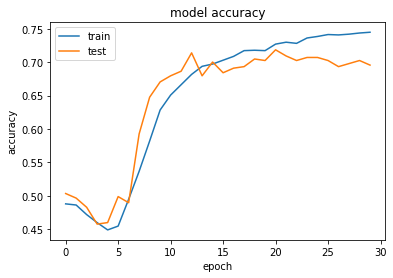

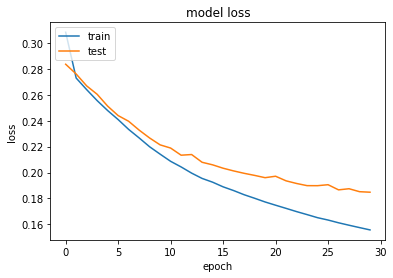

In [48]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# BERT

In [176]:
config = AutoConfig.from_pretrained("m3hrdadfi/albert-fa-base-v2")
tokenizer = AutoTokenizer.from_pretrained("m3hrdadfi/albert-fa-base-v2")
bert_model = AutoModel.from_pretrained("m3hrdadfi/albert-fa-base-v2")

In [178]:
def get_embedding(sent):
    input_sentence = torch.tensor(tokenizer.encode(sent, max_length = 500)).unsqueeze(0)
    out = bert_model(input_sentence)
    embeddings_of_last_layer = out[0]
    cls_embeddings = embeddings_of_last_layer[0][0]
    cls_embeddings = cls_embeddings.detach().numpy()
    return cls_embeddings

In [180]:
text = "ما در هوشواره معتقدیم با انتقال صحیح دانش و آگاهی، همه افراد می‌توانند از ابزارهای هوشمند استفاده کنند. شعار ما هوش مصنوعی برای همه است."
get_embedding(text).shape

(768,)

In [86]:
# df_types_bert = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types.csv")

In [90]:
# df_types_bert['sentence'] = df_types_bert['sentence'].apply(lambda sent: get_embedding(sent))
# df_types_bert.to_csv("/content/drive/My Drive/topics-for-types/df_types_bert.csv", index=False)
# df_types_bert.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[-0.5841074, -0.017078003, -0.32405344, -0.645...",0,0,0,0,1,1,0,0,0,1,0,0
1,"[-0.31120673, -0.0050979797, 0.10509731, -0.36...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[0.05544515, -0.23301096, 0.12021764, -0.33959...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[0.37881416, -0.1909234, 0.16427912, -0.383240...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[-0.46968994, -0.2401005, 0.20189604, -0.20498...",0,0,0,0,1,0,0,0,1,1,0,0


In [219]:
df_types_bert = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types_bert.csv")
df_types_bert['sentence'] = df_types_bert['sentence'].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' '))
df_types_bert.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[-0.584107399, -0.0170780029, -0.324053437, -0...",0,0,0,0,1,1,0,0,0,1,0,0
1,"[-0.311206728, -0.00509797968, 0.105097309, -0...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[0.0554451495, -0.233010963, 0.120217644, -0.3...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[0.378814161, -0.190923393, 0.164279118, -0.38...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[-0.469689935, -0.240100503, 0.201896042, -0.2...",0,0,0,0,1,0,0,0,1,1,0,0


In [220]:
X = np.array(df_types_bert[df_types_bert.columns[0]])
X = np.vstack(X)

Y = df_types[df_types_bert.columns[1:]].values

X.shape, Y.shape

((2424, 768), (2424, 12))

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

In [131]:
len(X_train),len(X_test),len(y_train),len(y_test)

(1939, 485, 1939, 485)

In [137]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X[0].shape, name='input_layer'),
    tf.keras.layers.Dense(200, activation='relu', name='Dense_Layer',
                          activity_regularizer=tf.keras.regularizers.l2()),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout"),
    tf.keras.layers.Dense(100, activation='relu', name='Dense_Layer2',
                          activity_regularizer=tf.keras.regularizers.l2()),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout2"),
    tf.keras.layers.Dense(12, activation='sigmoid', name='Dense_Layer3'),

  ], name='LASER_Model')

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "LASER_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer (Dense)          (None, 200)               153800    
_________________________________________________________________
Dense_Layer2 (Dense)         (None, 100)               20100     
_________________________________________________________________
Dense_Layer3 (Dense)         (None, 12)                1212      
Total params: 175,112
Trainable params: 175,112
Non-trainable params: 0
_________________________________________________________________
None


In [138]:
history = model.fit(X_train, y_train, batch_size=8, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
194/194 [==============================] - 1s 4ms/step - loss: 0.4704 - acc: 0.4765 - val_loss: 0.3635 - val_acc: 0.5077
Epoch 2/20
194/194 [==============================] - 1s 4ms/step - loss: 0.3239 - acc: 0.5222 - val_loss: 0.3112 - val_acc: 0.5412
Epoch 3/20
194/194 [==============================] - 1s 4ms/step - loss: 0.2840 - acc: 0.6686 - val_loss: 0.2806 - val_acc: 0.6907
Epoch 4/20
194/194 [==============================] - 1s 4ms/step - loss: 0.2672 - acc: 0.7137 - val_loss: 0.2728 - val_acc: 0.7216
Epoch 5/20
194/194 [==============================] - 1s 4ms/step - loss: 0.2566 - acc: 0.7124 - val_loss: 0.2685 - val_acc: 0.7320
Epoch 6/20
194/194 [==============================] - 1s 4ms/step - loss: 0.2494 - acc: 0.7266 - val_loss: 0.2661 - val_acc: 0.7268
Epoch 7/20
194/194 [==============================] - 1s 4ms/step - loss: 0.2407 - acc: 0.7221 - val_loss: 0.2766 - val_acc: 0.6005
Epoch 8/20
194/194 [==============================] - 1s 4ms/step - loss: 0.

In [139]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

16/16 [==============================] - 0s 2ms/step - loss: 0.2517 - acc: 0.6433
Test Score: 0.2517291307449341
Test Accuracy: 0.6432989835739136


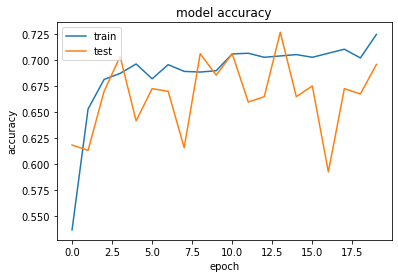

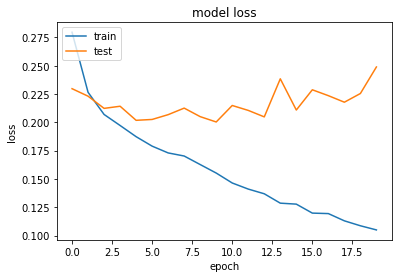

In [135]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()